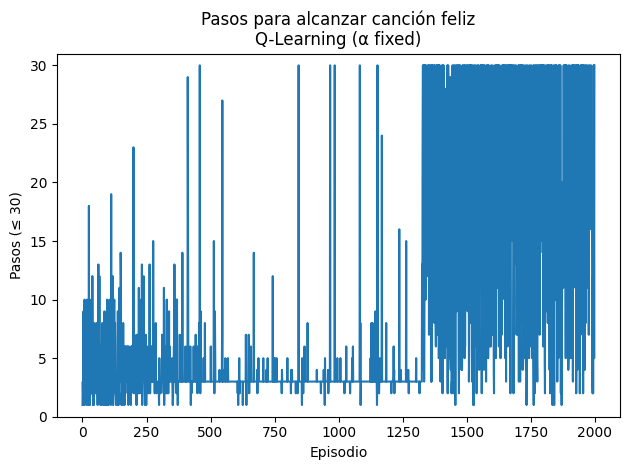

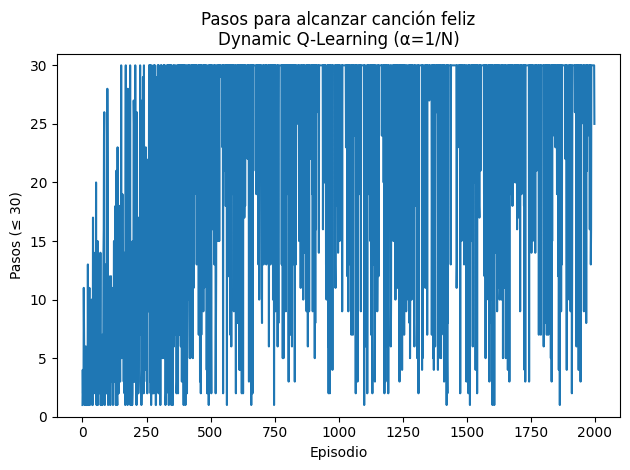

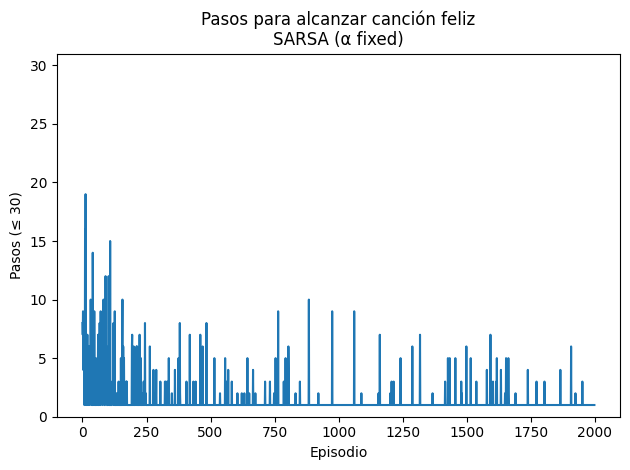

In [3]:
# -----------------------------------------------------------
# RL comparison on Spotify-like dataset: Q-Learning, Dynamic Q, SARSA
# Generates three separate plots (one per algorithm) showing
# "Episode vs. steps needed to reach a 'happy' song".
# -----------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
import os

# ---------- Parameters ----------
CSV_FILE      = "/mnt/data/dataset.csv"  # expected location
N_TRACKS      = 100                      # sample size
VALENCE_GOAL  = 0.8                      # threshold for "happy" (normalized)
EPISODES      = 2000
MAX_STEPS     = 30
GAMMA         = 0.90
ALPHA_CONST   = 0.15
EPSILON_START = 1.0
EPSILON_MIN   = 0.05
EPS_DECAY     = 0.995
SEED          = 42
np.random.seed(SEED)

# ---------- Load dataset ----------
need_cols = ["track_id", "track_name", "valence",
             "energy", "danceability", "popularity"]

if os.path.isfile(CSV_FILE):
    df_raw = pd.read_csv(CSV_FILE)
else:
    # Fallback: create synthetic dataset if file not present
    n_synth = 200
    df_raw = pd.DataFrame({
        "track_id": [f"ID{i:04}" for i in range(n_synth)],
        "track_name": [f"Track_{i}" for i in range(n_synth)],
        "valence": np.random.rand(n_synth),
        "energy": np.random.rand(n_synth),
        "danceability": np.random.rand(n_synth),
        "popularity": np.random.randint(0, 101, size=n_synth)
    })

missing = [c for c in need_cols if c not in df_raw.columns]
if missing:
    raise KeyError(f"Columns missing in dataset: {missing}")

df_raw = df_raw[need_cols].dropna().reset_index(drop=True)
if len(df_raw) < N_TRACKS:
    N_TRACKS = len(df_raw)

df = df_raw.sample(N_TRACKS, random_state=SEED).reset_index(drop=True)

# ---------- Normalization ----------
for col in ["valence", "energy", "danceability", "popularity"]:
    df[f"{col}_n"] = (df[col] - df[col].min()) / (df[col].max() - df[col].min() + 1e-8)

# ---------- Cosine similarity matrix ----------
vec = df[["valence_n", "energy_n", "danceability_n"]].values
vec /= np.linalg.norm(vec, axis=1, keepdims=True) + 1e-8
sim_mat = np.clip(vec @ vec.T, 0, 1)   # shape (N_TRACKS, N_TRACKS)

# Mark happy songs
df["happy"] = df["valence_n"] >= VALENCE_GOAL

# ---------- Environment dimensions ----------
N_STATES = N_TRACKS + 1   # song indices 0..N-1 plus initial state N
S_INIT   = N_TRACKS       # special initial state index

# ---------- Reward function ----------
w_val, w_eng, w_dnc, w_pop, w_sim = 1.0, 0.7, 0.7, 0.1, 0.4
def reward(prev_idx: int, act_idx: int) -> float:
    """Adaptive reward combining valence, arousal proxies and similarity."""
    r = (w_val * df.at[act_idx, "valence_n"] +
         w_eng * df.at[act_idx, "energy_n"] +
         w_dnc * df.at[act_idx, "danceability_n"] +
         w_pop * df.at[act_idx, "popularity_n"])
    if prev_idx != -1:
        r += w_sim * sim_mat[prev_idx, act_idx]
    return r

# ---------- Helper: epsilon-greedy ----------
def choose_action(Q_row, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(Q_row.size)
    return int(np.argmax(Q_row))

# ---------- Training loop ----------
def run_agent(agent_type: str):
    """
    agent_type: 'q', 'dq', or 'sarsa'
    Returns list of steps needed to reach a happy song each episode.
    """
    Q   = np.zeros((N_STATES, N_TRACKS), dtype=np.float32)
    Nsa = np.ones_like(Q, dtype=np.int32)  # visit counts for dynamic Q
    steps_ep = []
    epsilon = EPSILON_START

    for ep in trange(EPISODES, desc=f"{agent_type.upper():>5}", ncols=70, leave=False):
        state = -1  # start with no previous song
        for step in range(1, MAX_STEPS + 1):
            s_idx = S_INIT if state == -1 else state
            action = choose_action(Q[s_idx], epsilon)

            r       = reward(state, action)
            next_s  = action
            next_idx = next_s

            # Learning rate
            alpha = (1.0 / Nsa[s_idx, action]) if agent_type == 'dq' else ALPHA_CONST

            if agent_type == 'sarsa':
                next_a = choose_action(Q[next_idx], epsilon)
                target = r + GAMMA * Q[next_idx, next_a]
            else:  # q-learning variants
                target = r + GAMMA * np.max(Q[next_idx])

            Q[s_idx, action] += alpha * (target - Q[s_idx, action])

            if agent_type == 'dq':
                Nsa[s_idx, action] += 1

            # Goal reached?
            if df.at[action, "happy"]:
                steps_ep.append(step)
                break

            state = next_s
        else:
            steps_ep.append(MAX_STEPS)  # never reached within limit

        epsilon = max(EPSILON_MIN, epsilon * EPS_DECAY)

    return steps_ep

# ---------- Run all three agents ----------
steps_q    = run_agent('q')
steps_dq   = run_agent('dq')
steps_sarsa= run_agent('sarsa')

# ---------- Plotting ----------
# One figure per algorithm
algos = [("Q-Learning (α fixed)", steps_q),
         ("Dynamic Q-Learning (α=1/N)", steps_dq),
         ("SARSA (α fixed)", steps_sarsa)]

for title, steps in algos:
    plt.figure()
    plt.plot(steps)
    plt.title(f"Pasos para alcanzar canción feliz\n{title}")
    plt.xlabel("Episodio")
    plt.ylabel("Pasos (≤ 30)")
    plt.ylim(0, MAX_STEPS + 1)
    plt.tight_layout()
    plt.show()
